# **Reference:**

Chen, D., & Zhou, X. (2024). AttMoE: Attention with Mixture of Experts for remaining useful life prediction of lithium-ion batteries. Journal of Energy Storage, 84, 110780.

In [1]:
import numpy as np
import random
import math
import os
import scipy.io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import transformers
%matplotlib inline

from math import sqrt
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

D:\Anaconda3\envs\torch_11\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
D:\Anaconda3\envs\torch_11\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
D:\Anaconda3\envs\torch_11\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


# step 1. get device

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# step 2. load data from mat data

In [3]:
# convert str to datatime
def convert_to_time(hmm):
    year, month, day, hour, minute, second = int(hmm[0]), int(hmm[1]), int(hmm[2]), int(hmm[3]), int(hmm[4]), int(hmm[5])
    return datetime(year=year, month=month, day=day, hour=hour, minute=minute, second=second)


# load .mat file
def loadMat(matfile):
    data = scipy.io.loadmat(matfile)
    filename = matfile.split(".")[0]
    col = data[filename]
    col = col[0][0][0][0]
    size = col.shape[0]

    data = []
    for i in range(size):
        k = list(col[i][3][0].dtype.fields.keys())
        d1, d2 = {}, {}
        if str(col[i][0][0]) != 'impedance':
            for j in range(len(k)):
                t = col[i][3][0][0][j][0];
                l = [t[m] for m in range(len(t))]
                d2[k[j]] = l
        d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2
        data.append(d1)

    return data


# get capacity data of batteries
def getBatteryCapacity(Battery):
    cycle, capacity = [], []
    i = 1
    for Bat in Battery:
        if Bat['type'] == 'discharge':
            capacity.append(Bat['data']['Capacity'][0])
            cycle.append(i)
            i += 1
    return [cycle, capacity]


# get battery data
def getBatteryValues(Battery, Type='charge'):
    data=[]
    for Bat in Battery:
        if Bat['type'] == Type:
            data.append(Bat['data'])
    return data

In [4]:
Battary_list = ['B0005', 'B0006', 'B0007', 'B0018']

Battery = {}
for name in Battary_list:
    print('Load Dataset ' + name + '.mat ...')
    path = name + '.mat'
    data = loadMat(path)
    Battery[name] = getBatteryCapacity(data)              # 放电时的容量数据

Load Dataset B0005.mat ...
Load Dataset B0006.mat ...
Load Dataset B0007.mat ...
Load Dataset B0018.mat ...


# or step 2. load from .npy file

**If the above read fails, please load the .npy file.**

In [ ]:
Battery_list = ['B0005', 'B0006', 'B0007', 'B0018']
Battery = np.load('datasets/NASA/NASA.npy', allow_pickle=True)
Battery = Battery.item()

# step 3. capacity figure

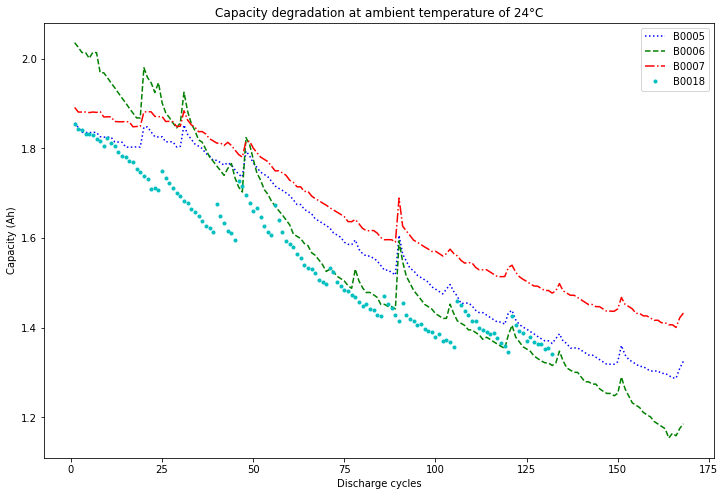

In [5]:
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
c = 0
for name,color in zip(Battary_list, color_list):
    df_result = Battery[name]
    ax.plot(df_result[0], df_result[1], color, label=name)
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 24°C')
plt.legend()

# step 4. define functions for data processing

In [6]:
def build_sequences(text, window_size):
    #text:list of capacity
    x, y = [],[]
    for i in range(len(text) - window_size):
        sequence = text[i:i+window_size]
        target = text[i+1:i+1+window_size]

        x.append(sequence)
        y.append(target)
        
    return np.array(x), np.array(y)


def split_dataset(data_sequence, train_ratio=0.0, capacity_threshold=0.0):
    if capacity_threshold > 0:
        max_capacity = max(data_sequence)
        capacity = max_capacity * capacity_threshold
        point = [i for i in range(len(data_sequence)) if data_sequence[i] < capacity]
    else:
        point = int(train_ratio + 1)
        if 0 < train_ratio <= 1:
            point = int(len(data_sequence) * train_ratio)
    train_data, test_data = data_sequence[:point], data_sequence[point:]
    return train_data, test_data


# 留一评估：一组数据为测试集，其他所有数据全部拿来训练
def get_train_test(data_dict, name, window_size=8):
    data_sequence=data_dict[name][1]
    train_data, test_data = data_sequence[:window_size+1], data_sequence[window_size+1:]
    train_x, train_y = build_sequences(text=train_data, window_size=window_size)
    for k, v in data_dict.items():
        if k != name:
            data_x, data_y = build_sequences(text=v[1], window_size=window_size)
            train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]
            
    return train_x, train_y, list(train_data), list(test_data)


def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), 0
    for i in range(len(y_test)-1):
        if y_test[i] <= threshold >= y_test[i+1]:
            true_re = i - 1
            break
    for i in range(len(y_predict)-1):
        if y_predict[i] <= threshold:
            pred_re = i - 1
            break
    return abs(true_re - pred_re)/true_re


def evaluation(y_test, y_predict):
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return mae, rmse
    
    
def setup_seed(seed):
    np.random.seed(seed)
    random.seed(seed) 
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed) 
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

# step 5. build net

In [7]:
from mixture_of_experts import MoE

class Attention(nn.Module):
    def __init__(self, feature_size, hidden_dim, nhead=4, dropout=0.0):
        super(Attention, self).__init__()
        self.query = nn.Linear(feature_size, hidden_dim)
        self.key = nn.Linear(feature_size, hidden_dim)
        self.value = nn.Linear(feature_size, hidden_dim)
        self.attn = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=nhead, dropout=dropout, batch_first=True)
        
    def forward(self, x):
        query, key, value = self.query(x), self.key(x), self.value(x)
        out, _ = self.attn(query, key, value)
        return out


class AttMoE(nn.Module):
    def __init__(self, feature_size=16, hidden_dim=8, num_layers=1, nhead=4, dropout=0., dropout_rate=0.2, 
                 num_experts=8, device='cpu'):
        super(AttMoE, self).__init__()
        self.feature_size, self.hidden_dim = feature_size, hidden_dim
        self.dropout = nn.Dropout(dropout_rate)
        self.cell = Attention(feature_size=feature_size, hidden_dim=hidden_dim, nhead=nhead, dropout=dropout)
        self.linear = nn.Linear(hidden_dim, 1)
        
        experts = nn.Linear(hidden_dim, hidden_dim)
        # create moe layers based on the number of experts
        self.moe = MoE(dim=hidden_dim, num_experts=num_experts, experts=experts)
        self.moe = self.moe.to(device)
 
    def forward(self, x): 
        out = self.dropout(x)
        out = self.cell(x)   # cell 输出 shape (batch_size, seq_len=1, feature_size)
        out,_ = self.moe(out)
        out = out.reshape(-1, self.hidden_dim) # (batch_size, hidden_dim)
        out = self.linear(out)  # shape: (batch_size, 1)
        
        return out

# step 6. define train function

In [8]:
def train(lr=0.01, feature_size=8, hidden_dim=32, num_layers=1, nhead=8, weight_decay=0.0, EPOCH=1000, 
          seed=0, dropout=0.0, metric='re', num_experts=8, device='cpu'):
    score_list, result_list = [], []
    for i in range(4):
        name = Battary_list[i]
        window_size = feature_size
        train_x, train_y, train_data, test_data = get_train_test(Battery, name, window_size)
        train_size = len(train_x)
        #print('sample size: {}'.format(train_size))

        setup_seed(seed)
        model = AttMoE(feature_size=feature_size, hidden_dim=hidden_dim, num_layers=num_layers, 
                        nhead=nhead, dropout=dropout, num_experts=num_experts, device=device)
        model = model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = nn.MSELoss()

        test_x = train_data.copy()
        loss_list, y_ = [0], []
        mae, rmse, re = 1, 1, 1
        score_, score = [1],[1]
        for epoch in range(EPOCH):
            X = np.reshape(train_x/Rated_Capacity,(-1, 1, feature_size)).astype(np.float32)#(batch_size, seq_len, input_size)
            y = np.reshape(train_y[:,-1]/Rated_Capacity,(-1,1)).astype(np.float32)# shape 为 (batch_size, 1)

            X, y = torch.from_numpy(X), torch.from_numpy(y)
            X, y = X.to(device), y.to(device)
            output = model(X)
            output = output.reshape(-1, 1)
            loss = criterion(output, y)
            optimizer.zero_grad()              # clear gradients for this training step
            loss.backward()                    # backpropagation, compute gradients
            optimizer.step()                   # apply gradients

            if (epoch + 1)%100 == 0:
                test_x = train_data.copy() #每100次重新预测一次
                point_list = []
                while (len(test_x) - len(train_data)) < len(test_data):
                    x = np.reshape(np.array(test_x[-feature_size:])/Rated_Capacity,(-1, 1, feature_size)).astype(np.float32)
                    x = torch.from_numpy(x) #(batch_size,feature_size=1,input_size)
                    x = x.to(device)
                    pred = model(x) # 测试集 模型预测#pred shape为(batch_size=1, feature_size=1)
                    next_point = pred.cpu().data.numpy()[0,0] * Rated_Capacity
                    test_x.append(next_point)#测试值加入原来序列用来继续预测下一个点
                    point_list.append(next_point)#保存输出序列最后一个点的预测值
                y_.append(point_list)#保存本次预测所有的预测值
                loss_list.append(loss)
                mae, rmse = evaluation(y_test=test_data, y_predict=y_[-1])
                re = relative_error(y_test=test_data, y_predict=y_[-1], threshold=Rated_Capacity*0.7)
                #print('epoch:{:<2d} | loss:{:<6.4f} | MAE:{:<6.4f} | RMSE:{:<6.4f} | RE:{:<6.4f}'.format(epoch, loss, mae, rmse, re))
            if metric == 're':
                score = [re]
            elif metric == 'mae':
                score = [mae]
            elif metric == 'rmse':
                score = [rmse]
            else:
                score = [re, mae, rmse]
            if (loss < 1e-3) and (score_[0] < score[0]):
                break
            score_ = score.copy()
            
        score_list.append(score_)
        result_list.append(y_[-1])
    return score_list, result_list

# step 7. grid-search to find key parameters

In [9]:
Rated_Capacity = 2.0
feature_size = 16
EPOCH = 2000
num_layers = 1
nhead = 4
weight_decay = 0.0
dropout = 0.0
metric = 'all'

for lr in [1e-4, 1e-3]:
    for hidden_dim in [32, 64, 128, 256]:
        for num_experts in [4, 8]:
            print('lr:{}, hidden_dim:{}, num_experts:{}'.format(lr, hidden_dim, num_experts))

            SCORE = []
            for seed in range(5):
                print('seed:{}'.format(seed))
                score_list, _ = train(lr=lr, feature_size=feature_size, hidden_dim=hidden_dim, num_layers=num_layers, 
                                      nhead=nhead, weight_decay=weight_decay, EPOCH=EPOCH, seed=seed, dropout=dropout, 
                                      metric=metric, num_experts=num_experts, device=device)
                print('------------------------------------------------------------------')
                for s in score_list:
                    SCORE.append(s)

            if metric != 'all':
                print(metric + ' mean: {:<6.4f}'.format(np.mean(np.array(SCORE))))
            else:
                mlist = ['re', 'mae', 'rmse']
                for i in range(3):
                    s = [line[i] for line in SCORE]
                    print(mlist[i] + ' mean: {:<6.4f}'.format(np.mean(np.array(s))))
            print('===================================================================')

lr:0.0001, hidden_dim:32, num_experts:4
seed:0
------------------------------------------------------------------
seed:1
------------------------------------------------------------------
seed:2
------------------------------------------------------------------
seed:3
------------------------------------------------------------------
seed:4
------------------------------------------------------------------
re mean: 0.5295
mae mean: 0.1714
rmse mean: 0.1822
lr:0.0001, hidden_dim:32, num_experts:8
seed:0
------------------------------------------------------------------
seed:1
------------------------------------------------------------------
seed:2
------------------------------------------------------------------
seed:3
------------------------------------------------------------------
seed:4
------------------------------------------------------------------
re mean: 0.4866
mae mean: 0.1552
rmse mean: 0.1668
lr:0.0001, hidden_dim:64, num_experts:4
seed:0
-------------------------------

------------------------------------------------------------------
seed:4
------------------------------------------------------------------
re mean: 0.2407
mae mean: 0.0693
rmse mean: 0.0779


# step 8. set the obtained best parameters

In [15]:
lr = 0.0001    # learning rate
hidden_dim = 64
num_experts = 8

Rated_Capacity = 2.0
feature_size = 16
EPOCH = 2000
num_layers = 1
nhead = 4
weight_decay = 0.0
dropout = 0.0
metric = 'all'


SCORE = []
for seed in range(5):
    print('seed:{}'.format(seed))
    score_list, _ = train(lr=lr, feature_size=feature_size, hidden_dim=hidden_dim, num_layers=num_layers, 
                          nhead=nhead, weight_decay=weight_decay, EPOCH=EPOCH, seed=seed, dropout=dropout, 
                          metric=metric, num_experts=num_experts, device=device)
    print('------------------------------------------------------------------')
    for s in score_list:
        SCORE.append(s)

if metric != 'all':
    print(metric + ' mean: {:<6.4f}'.format(np.mean(np.array(SCORE))))
else:
    mlist = ['re', 'mae', 'rmse']
    for i in range(3):
        s = [line[i] for line in SCORE]
        print(mlist[i] + ' mean: {:<6.4f}'.format(np.mean(np.array(s))))
print('===================================================================')

seed:0
------------------------------------------------------------------
seed:1
------------------------------------------------------------------
seed:2
------------------------------------------------------------------
seed:3
------------------------------------------------------------------
seed:4
------------------------------------------------------------------
re mean: 0.2000
mae mean: 0.0760
rmse mean: 0.0872
